## Классификация объявлений о продаже мяса

## Задача ##
Дан датасет с частными объявлениями о продаже мяса. Требуется классифицировать, какой вид мяса предлагается в объявлении. Пример датасета:

**Текст**: "Бедро Цб 106 руб.гост Бедро ЦБ 106 руб.ГОСТ 
Вся продукция высокого качества!"

**Класс**: Цыпленок

=========================================

**Текст**: "Вырезка Свиная Вырезка свиная цена 260р В наличии в Новосибирске"

**Класс**: Свинина

=========================================

**Текст**: "быки замороженные быки замороженные 1 категория, п/туши, производство РБ, цена с НДС 160 руб/кг"

**Класс**: Говядина


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import data_table

In [ ]:
df = pd.read_csv('./meatinfo.csv', sep=';', on_bad_lines='skip')

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17892 entries, 0 to 17892
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17892 non-null  object
 1   mtype   17892 non-null  object
dtypes: object(2)
memory usage: 419.3+ KB


In [ ]:
# отбираем только те классы, где есть хотя бы 500 записей
classes = df.mtype.value_counts()
classes = classes[classes > 500]
data = df.loc[df.mtype.isin(classes.index)]


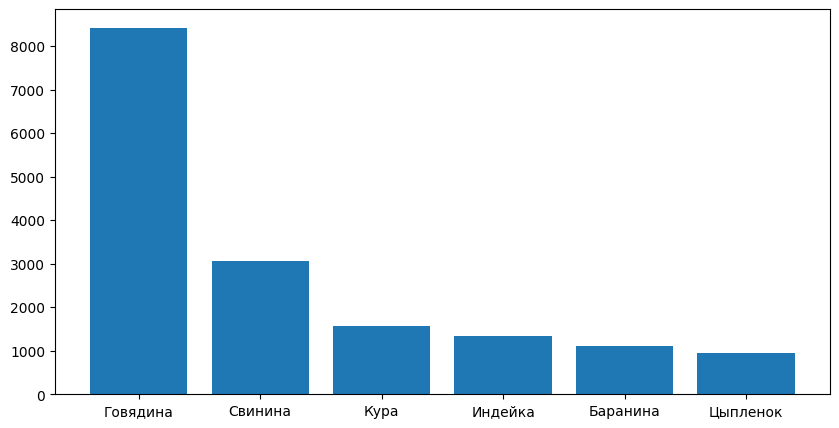

In [ ]:
# проверка сбалансированности выборок по классам
fig = plt.figure(figsize=(10, 5))
plt.bar(classes.index, classes)
plt.show()

In [ ]:
# датасет не сбалансированный, но, как выяснилось из экспериментов,
# это не уменьшает точности классификации в этой задаче, поэтому
# следующий шаг необязателен

# обрежем не более 2000 элементов для каждого класса
for cls in classes.index:
    data = data.drop(data[data.mtype == cls].index[2000:])


In [ ]:
texts = data.text.tolist()
mtypes = data.mtype.tolist()

In [ ]:
VOCAB_SIZE       = 1000                  # берем первые 1000 самых частых слов
TRAIN_TEST_RATIO = 0.2                   # Разбивка 20% на тест

In [ ]:
# токенизируем тексты встроенным токенайзером кераса
tokenizer = Tokenizer(
                num_words=VOCAB_SIZE,
                filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                lower=True,
                split=' ',
                oov_token='unknown',
                char_level=False
            )
tokenizer.fit_on_texts(texts)
items = list(tokenizer.word_index.items())

In [ ]:
# кодируем метки классов
encoder = LabelEncoder()
class_labels = encoder.fit_transform(mtypes)

CLASS_LIST = encoder.classes_
CLASS_COUNT = len(CLASS_LIST)

print(f'Список классов: {CLASS_LIST}')
print(f'Всего классов: {CLASS_COUNT}')
print(f'Форма выходных данных: {class_labels.shape}')

Список классов: ['Баранина' 'Говядина' 'Индейка' 'Кура' 'Свинина' 'Цыпленок']
Всего классов: 6
Форма выходных данных: (8966,)


In [ ]:
# преобразуем входные данные в формат Bag-of-Words
x_data = tokenizer.texts_to_matrix(texts)
print('Формат входных данных: ', x_data.shape)
print('Пример входных данных: ', x_data[0, :20])

# преобразуем выходные данные к векторам One Hot Encoding
y_data = utils.to_categorical(class_labels, CLASS_COUNT)
print('Формат выходных данных:', y_data.shape)
print('Пример выходных данных:', y_data[0])

Формат входных данных:  (8966, 1000)
Пример входных данных:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Формат выходных данных: (8966, 6)
Пример выходных данных: [1. 0. 0. 0. 0. 0.]


In [ ]:
# делим на тренировочную и тестовую выборки
idx_train, idx_test = train_test_split(list(range(len(x_data))),
                                       stratify=y_data,
                                       test_size=TRAIN_TEST_RATIO)

x_train, x_test = x_data[idx_train], x_data[idx_test]
y_train, y_test = y_data[idx_train], y_data[idx_test]

# Проверка результата
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(7172, 1000) (1794, 1000)
(7172, 6) (1794, 6)


In [ ]:
# функция компиляции и обучения модели нейронной сети
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    # обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(6, 6)):

    y_pred = model.predict(x)
    # построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    cm = np.around(cm, cm_round)
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title('Матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)
    plt.show()

    print('\nСреднее диагональных элементов: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(6, 6)):

    # компиляция и обучение модели на заданных параметрах
    # в качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                16016     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 16,118
Trainable params: 16,118
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
225/225 [==============================] - 9s 10ms/step - loss: 1.3929 - accuracy: 0.5452 - val_loss: 0.8997 - val_accuracy: 0.8484
Epoch 2/20
225/225 [==============================] - 1s 6ms/step - loss: 0.7717 - accuracy: 0.7945 - val_loss: 0.4550 - val_accuracy: 0.9197
Epoch 3/20
225/225 [===========

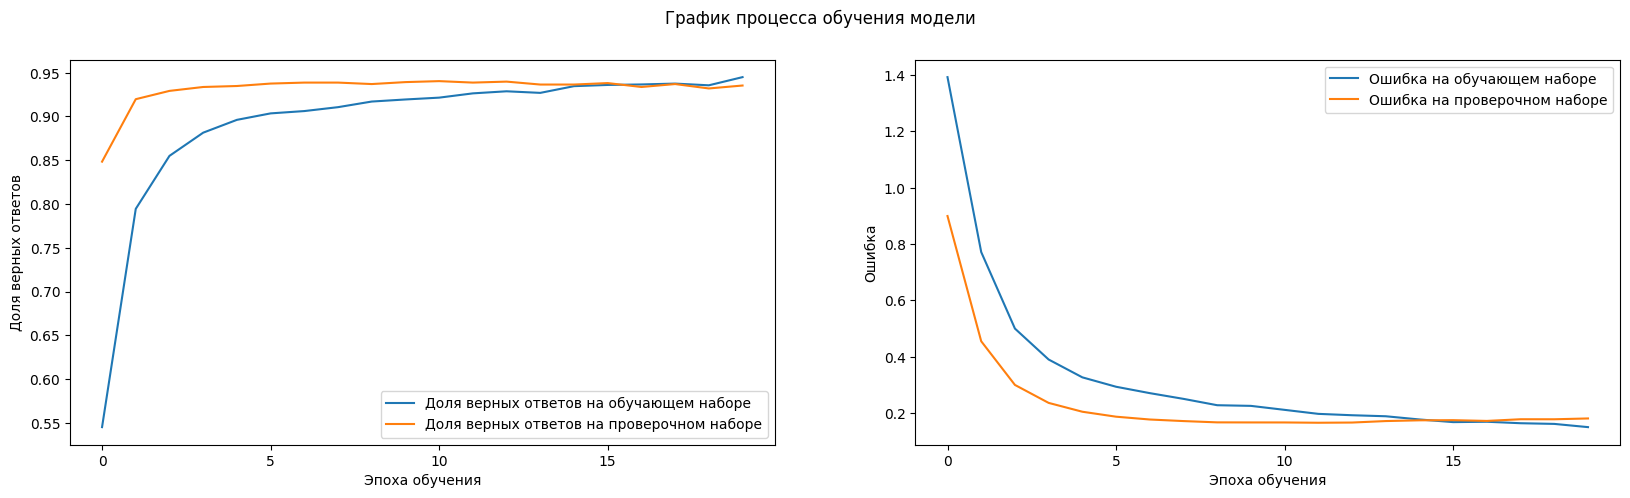

57/57 [==============================] - 0s 2ms/step


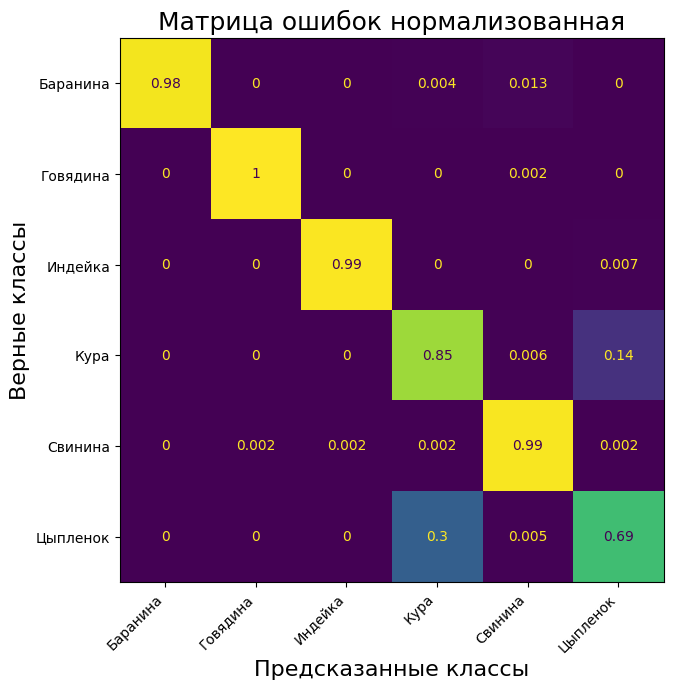


Среднее диагональных элементов:  92%


In [ ]:
# последовательная модель
model_text_bow_dense = Sequential()
# входной полносвязный слой
model_text_bow_dense.add(Dense(16, input_dim=VOCAB_SIZE, activation="relu"))
# слой регуляризации Dropout
model_text_bow_dense.add(Dropout(0.4))

# более глубокая нейросеть выигрыша в точности не дала - можно опустить
# # второй полносвязный слой
# model_text_bow_dense.add(Dense(32, activation='relu'))
# # слой регуляризации Dropout
# model_text_bow_dense.add(Dropout(0.4))
# # третий полносвязный слой
# model_text_bow_dense.add(Dense(32, activation='relu'))
# # слой регуляризации Dropout
# model_text_bow_dense.add(Dropout(0.4))
# # выходной полносвязный слой
model_text_bow_dense.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_text_bow_dense,
                         x_train, y_train,
                         x_test, y_test,
                         epochs=20,
                         batch_size=32,
                         cm_size=(8, 8),
                         class_labels=CLASS_LIST
                         )

In [ ]:
model_text_bow_dense.save('meat_model.h5')

## Итоги


Bag-of-Words и простейшая полносвязная нейросеть показали точность классификации - **91%**.
Основная ошибка связана с разнесением классов **Цыпленок** - **Кура**.
Если посмотреть датасет внимательно, то станет понятно почему (см.ниже).

По одному текстовому описанию разделить эти два класса невозможно даже человеку - т.к. по сути, тексты для **Куры** и для **Цыпленка** - часто одинаковые.

Если мы **Цыпленка** и **Куру** берем за один класс (это мое обывательское мнение - возможно между ними большая разница), тогда точность распознавания составит **99%**.

In [ ]:
np.mean(0.98+1+0.99+(0.85+0.14)+0.99+(0.69+0.3))/6

0.9900000000000001

In [ ]:
data_table.enable_dataframe_formatter()
data.iloc[200:210]

# обратите внимание, например, на строки 207 и 209

,text,mtype
201,"Бедро кур б/х мон. ГОСТ 117.00 руб ООО ""Руспти...",Цыпленок
202,"Бедро кур б/х н/п ГОСТ 120.00 руб ООО ""Русптиц...",Цыпленок
203,Бедро кур б/хр 121.00 руб ООО РУСПТИЦА г.Москв...,Цыпленок
204,Бедро кур. без хребта Бедро кур. б/хр ГОСТ 69р...,Кура
205,Бедро кур. Вес. ТУ. 97 р/кг. Бедро кур. Вес. Т...,Цыпленок
206,Бедро кур. зам. ГОСТ. на подложке Бедро курино...,Цыпленок
207,Бедро кур. подл.115 р Кпф,Цыпленок
208,"Бедро куринное ""Здоровая Ферма"" Предлагаем к р...",Цыпленок
209,Бедро куриное,Кура
210,Бедро куриное натуральное Бедро куриное нату...,Кура


In [ ]:
# функция получения предсказания от нейросети по одному текстовому объявлению
def test(s):
    x = tokenizer.texts_to_sequences([s])
    x = pad_sequences(x, maxlen=VOCAB_SIZE)
    x = tokenizer.texts_to_matrix([s])
    y_pred = model_text_bow_dense.predict(x, verbose=0)
    class_idx = np.argmax(y_pred[0])
    return(CLASS_LIST[class_idx])

In [ ]:
# проверяем на тестовых текстах из задания
test_texts = [
    'Говядина блочная 2 сорт в наличии ООО "АгроСоюз" реализует блочную говядину 2 сорт (80/20) Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.',
    'Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:',
    'Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем.'
]
for text in test_texts:
    pred_class = test(text)
    print('Текст:', text)
    print('Результат распознавания:', pred_class)
    print('='*50)

Текст: Говядина блочная 2 сорт в наличии ООО "АгроСоюз" реализует блочную говядину 2 сорт (80/20) Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.
Результат распознавания: Говядина
Текст: Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:
Результат распознавания: Кура
Текст: Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем.
Результат распознавания: Говядина
